In [1]:
import pandas as pd
import numpy as np
import sys; sys.path.append("..")
from trader.data.binance import Binance
from trader.strategies.util import robust_vol
from trader.backtest.pnl import PnL

In [2]:
b = Binance(test=False)

In [19]:
bars = b.get_bars(["ETHBTC"], pd.to_datetime("2022-08-15"), pd.to_datetime("2022-08-20"), interval="1h")

In [20]:
closes = bars.pivot(index="CloseTime", values="Close", columns = "Symbol")

In [21]:
closes.head()

Symbol,ETHBTC
CloseTime,
2022-08-15 02:00:00,0.080097
2022-08-15 03:00:00,0.080268
2022-08-15 04:00:00,0.079865
2022-08-15 05:00:00,0.079796
2022-08-15 06:00:00,0.079355


In [23]:
eth = closes.ETHBTC.to_frame("Close")
eth["Signal"] = 0
eth["MA"] = eth.Close.rolling(30).mean()
eth["Std"] = robust_vol(eth.Close)
eth["Upper"] = eth.MA + eth.Std * 1.5
eth["Lower"] = eth.MA - eth.Std * 1.5

<AxesSubplot:xlabel='CloseTime'>

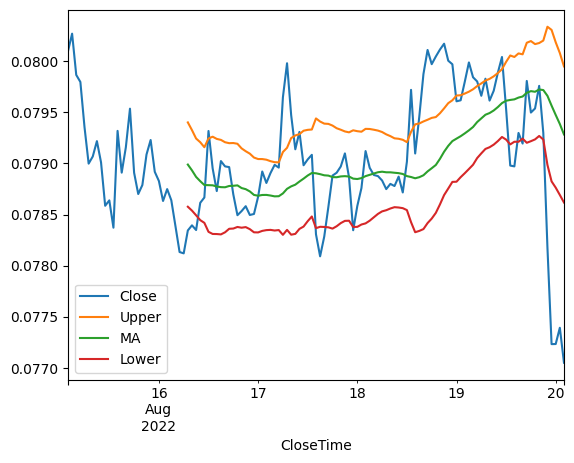

In [24]:
eth[["Close", "Upper", "MA", "Lower"]].plot()

In [25]:
signal = 0
for i in range(1, eth.shape[0]):
    idx = eth.index[i]
    row = eth.iloc[i-1]
    if pd.isna(row.Upper):
        continue
    if (row.Close > row.Upper) and (signal == 0): #Enter short if above upper
        signal = -1
    elif (row.Close < row.MA) and (signal == -1): #Exit if crossing mean and already short
        signal = 0
    elif (row.Close < row.Lower) and (signal == 0): #Enter long if below lower
        signal = 1
    elif (row.Close > row.MA) and (signal == 1): #Exit if crossing mean and already low
        signal = 0
    eth.loc[idx, "Signal"] = signal
eth.loc[eth.Signal < 0, "Signal"] = 0

<AxesSubplot:xlabel='CloseTime'>

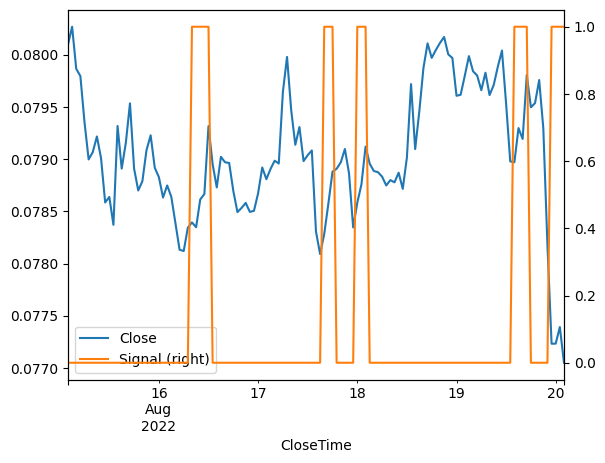

In [26]:
eth[["Close", "Signal"]].plot(secondary_y="Signal")

<AxesSubplot:xlabel='CloseTime'>

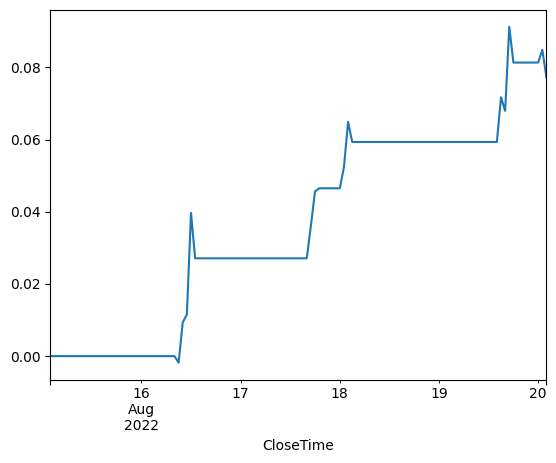

In [27]:
pp = PnL(eth.Signal, eth.Close)
pp.pnl.cumsum().plot()

<AxesSubplot:xlabel='CloseTime'>

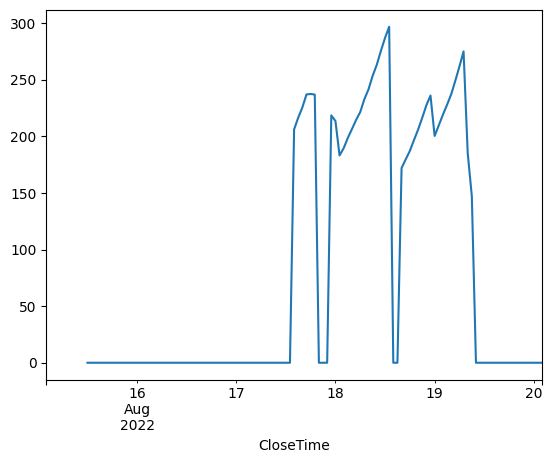

In [13]:
pp.get_position().plot()